In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    #x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    #x = Dense(128, activation='relu')(x)
    #x = Dropout(0.3)(x)
    #x = Flatten()(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(0.3)(x)
    #x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldInceptionV3.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 13s 117ms/step
Epoch 1 - Validation Loss: 1.3440, Validation Accuracy: 0.5050, Validation Precision: 0.7752

Epoch 1: val_loss improved from inf to 1.34396, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 243s - loss: 0.7409 - acc: 0.7412 - val_loss: 1.3440 - val_acc: 0.5050 - lr: 1.0000e-04 - 243s/epoch - 607ms/step
Epoch 2/1000
101/101 [==============================] - 12s 118ms/step
Epoch 2 - Validation Loss: 0.5268, Validation Accuracy: 0.8192, Validation Precision: 0.8127

Epoch 2: val_loss improved from 1.34396 to 0.52676, saving model to 5foldInceptionV3.h5
401/401 - 217s - loss: 0.5110 - acc: 0.8177 - val_loss: 0.5268 - val_acc: 0.8192 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 3/1000
101/101 [==============================] - 12s 119ms/step
Epoch 3 - Validation Loss: 0.5101, Validation Accuracy: 0.8067, Validation Precision: 0.8258

Epoch 3: val_loss improved from 0.52676 to 0.51005, saving model to 5foldInceptionV3.h5
401/401 - 221s - loss: 0.4087 - acc: 0.8520 - val_loss: 0.5101 - val_acc: 0.8067 - lr: 1.0000e-04 - 221s/epoch - 552ms/step
Epoch 4/1000
101/101 [==============================] - 12s 118ms/step
Epoch 4 - Validation Loss: 0.5344, Validation Accur

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 114ms/step
Epoch 4 - Validation Loss: 0.8662, Validation Accuracy: 0.7263, Validation Precision: 0.8163

Epoch 4: val_loss did not improve from 0.52086
401/401 - 210s - loss: 0.3542 - acc: 0.8692 - val_loss: 0.8662 - val_acc: 0.7263 - lr: 1.0000e-04 - 210s/epoch - 524ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 114ms/step
Epoch 5 - Validation Loss: 0.4991, Validation Accuracy: 0.8392, Validation Precision: 0.8578

Epoch 5: val_loss improved from 0.52086 to 0.49910, saving model to 5foldInceptionV3.h5
401/401 - 212s - loss: 0.3194 - acc: 0.8846 - val_loss: 0.4991 - val_acc: 0.8392 - lr: 1.0000e-04 - 212s/epoch - 529ms/step
Epoch 6/1000
101/101 [==============================] - 12s 114ms/step
Epoch 6 - Validation Loss: 0.6277, Validation Accuracy: 0.8298, Validation Precision: 0.8517

Epoch 6: val_loss did not improve from 0.49910
401/401 - 209s - loss: 0.2624 - acc: 0.9055 - val_loss: 0.6277 - val_acc: 0.8298 - lr: 1.0000e-04 - 209s/epoch - 521ms/step
Epoch 7/1000
101/101 [==============================] - 12s 114ms/step
Epoch 7 - Validation Loss: 1.0844, Validation Accuracy: 0.7537, Validation Precision: 0.8598

Epoch 7: val_loss did not improve from 0.49910
401/401 - 211s - loss: 0.2371 - acc: 0.9138 - val_loss: 1.0844 - val_acc: 0.7537 - lr: 1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 220s - loss: 0.7908 - acc: 0.7228 - val_loss: 0.5761 - val_acc: 0.8024 - lr: 1.0000e-04 - 220s/epoch - 547ms/step
Epoch 2/1000
101/101 [==============================] - 12s 114ms/step
Epoch 2 - Validation Loss: 0.6890, Validation Accuracy: 0.7519, Validation Precision: 0.8231

Epoch 2: val_loss did not improve from 0.57609
401/401 - 214s - loss: 0.5557 - acc: 0.8011 - val_loss: 0.6890 - val_acc: 0.7519 - lr: 1.0000e-04 - 214s/epoch - 535ms/step
Epoch 3/1000
101/101 [==============================] - 12s 114ms/step
Epoch 3 - Validation Loss: 0.6500, Validation Accuracy: 0.7824, Validation Precision: 0.8276

Epoch 3: val_loss did not improve from 0.57609
401/401 - 214s - loss: 0.4517 - acc: 0.8302 - val_loss: 0.6500 - val_acc: 0.7824 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 4/1000
101/101 [==============================] - 12s 115ms/step
Epoch 4 - Validation Loss: 0.6278, Validation Accuracy: 0.7849, Validation Precision: 0.8360

Epoch 4: val_loss did not improve from 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 222s - loss: 0.7256 - acc: 0.7454 - val_loss: 0.7886 - val_acc: 0.7642 - lr: 1.0000e-04 - 222s/epoch - 553ms/step
Epoch 2/1000
101/101 [==============================] - 12s 114ms/step
Epoch 2 - Validation Loss: 1.0267, Validation Accuracy: 0.6937, Validation Precision: 0.8239

Epoch 2: val_loss did not improve from 0.78862
401/401 - 213s - loss: 0.5196 - acc: 0.8148 - val_loss: 1.0267 - val_acc: 0.6937 - lr: 1.0000e-04 - 213s/epoch - 532ms/step
Epoch 3/1000
101/101 [==============================] - 12s 114ms/step
Epoch 3 - Validation Loss: 0.5390, Validation Accuracy: 0.8141, Validation Precision: 0.8330

Epoch 3: val_loss improved from 0.78862 to 0.53903, saving model to 5foldInceptionV3.h5
401/401 - 214s - loss: 0.4290 - acc: 0.8486 - val_loss: 0.5390 - val_acc: 0.8141 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 4/1000
101/101 [==============================] - 12s 115ms/step
Epoch 4 - Validation Loss: 0.9861, Validation Accuracy: 0.7386, Validation Precision: 0.8106

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 219s - loss: 0.7256 - acc: 0.7456 - val_loss: 2.1490 - val_acc: 0.3206 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 2/1000
101/101 [==============================] - 12s 114ms/step
Epoch 2 - Validation Loss: 3.2901, Validation Accuracy: 0.2233, Validation Precision: 0.7378

Epoch 2: val_loss did not improve from 2.14895
401/401 - 214s - loss: 0.5058 - acc: 0.8206 - val_loss: 3.2901 - val_acc: 0.2233 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 113ms/step
Epoch 3 - Validation Loss: 0.7035, Validation Accuracy: 0.7205, Validation Precision: 0.7962

Epoch 3: val_loss improved from 2.14895 to 0.70350, saving model to 5foldInceptionV3.h5
401/401 - 215s - loss: 0.4182 - acc: 0.8466 - val_loss: 0.7035 - val_acc: 0.7205 - lr: 1.0000e-04 - 215s/epoch - 535ms/step
Epoch 4/1000
101/101 [==============================] - 12s 113ms/step
Epoch 4 - Validation Loss: 2.0574, Validation Accuracy: 0.3712, Validation Precision: 0.8076

Epoch 4: val_loss did not improve from 0.70350
401/401 - 214s - loss: 0.3614 - acc: 0.8673 - val_loss: 2.0574 - val_acc: 0.3712 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 5/1000
101/101 [==============================] - 12s 114ms/step
Epoch 5 - Validation Loss: 0.8353, Validation Accuracy: 0.7112, Validation Precision: 0.8096

Epoch 5: val_loss did not improve from 0.70350
401/401 - 214s - loss: 0.2946 - acc: 0.8962 - val_loss: 0.8353 - val_acc: 0.7112 - lr: 1

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 299, 224, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 299, 224, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                           

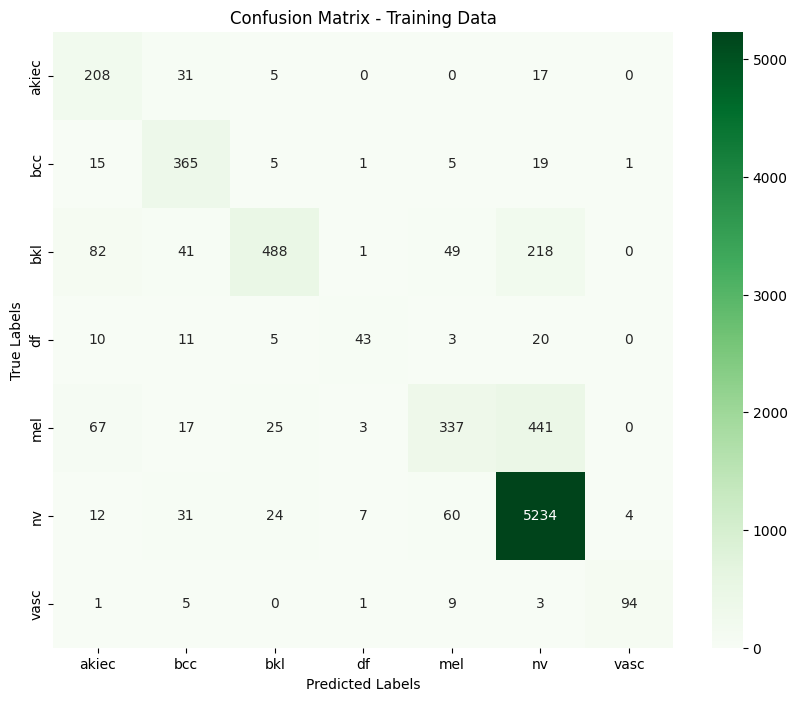

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.53      0.80      0.63       261
         bcc       0.73      0.89      0.80       411
         bkl       0.88      0.56      0.68       879
          df       0.77      0.47      0.58        92
         mel       0.73      0.38      0.50       890
          nv       0.88      0.97      0.92      5372
        vasc       0.95      0.83      0.89       113

    accuracy                           0.84      8018
   macro avg       0.78      0.70      0.72      8018
weighted avg       0.84      0.84      0.83      8018

126/126 [==============================] - 14s 113ms/step


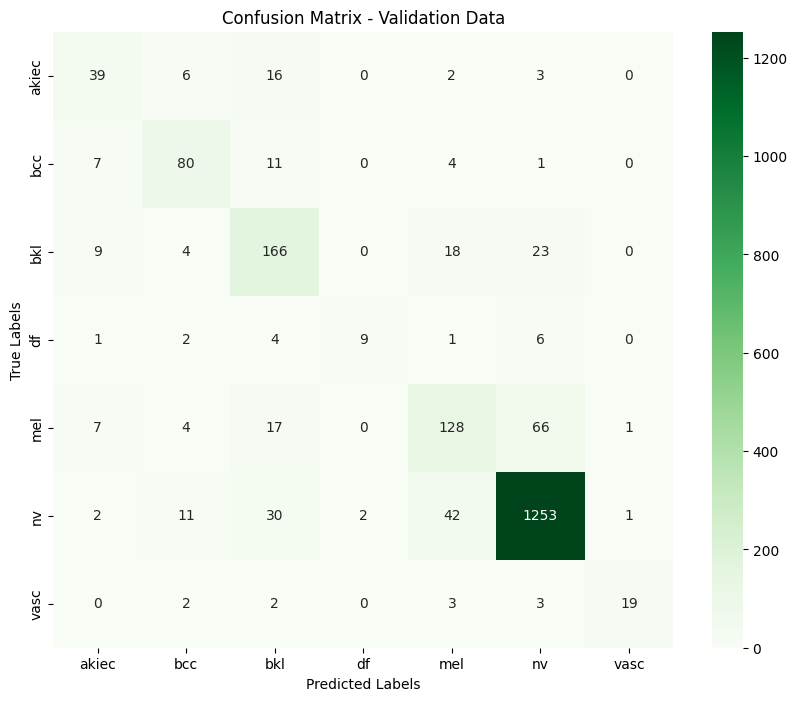

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.60      0.59      0.60        66
         bcc       0.73      0.78      0.75       103
         bkl       0.67      0.75      0.71       220
          df       0.82      0.39      0.53        23
         mel       0.65      0.57      0.61       223
          nv       0.92      0.93      0.93      1341
        vasc       0.90      0.66      0.76        29

    accuracy                           0.84      2005
   macro avg       0.76      0.67      0.70      2005
weighted avg       0.84      0.84      0.84      2005

95/95 [==============================] - 11s 114ms/step


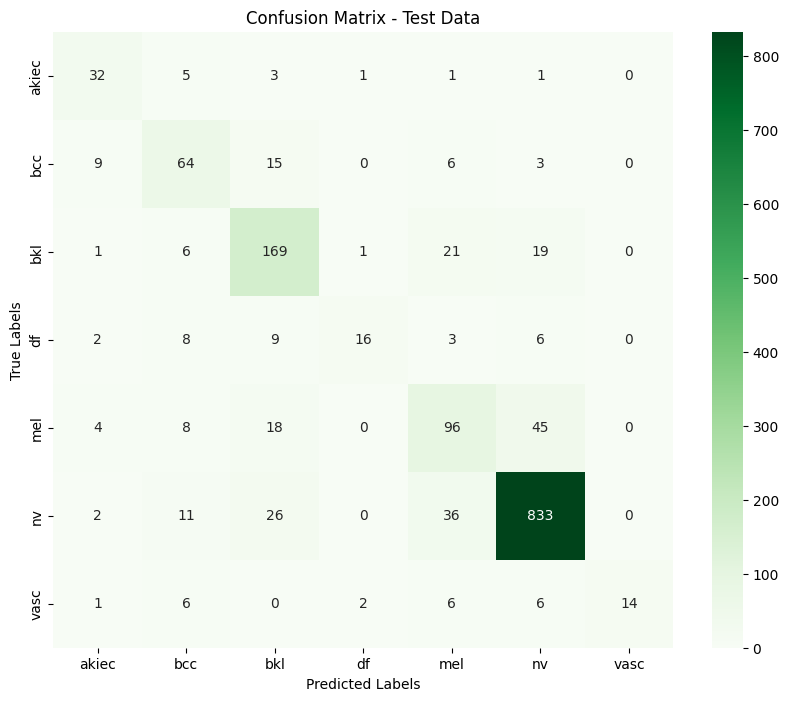

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.63      0.74      0.68        43
         bcc       0.59      0.66      0.62        97
         bkl       0.70      0.78      0.74       217
          df       0.80      0.36      0.50        44
         mel       0.57      0.56      0.56       171
          nv       0.91      0.92      0.91       908
        vasc       1.00      0.40      0.57        35

    accuracy                           0.81      1515
   macro avg       0.74      0.63      0.66      1515
weighted avg       0.81      0.81      0.81      1515



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldInceptionV3.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')